In [39]:
# Импортируем библиотеки
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
from scipy import stats
%matplotlib inline

In [79]:
# Подключаемся к базе данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220620'
}

1. Проведем сравнение тестов между группами 0 и 3

In [80]:
# Создаем запрос
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

# Загружаем данные из clickhouse
df = ph.read_clickhouse(q, connection=connection)

In [81]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545
...,...,...,...,...,...
20043,3,13781,10,27,0.370370
20044,3,130651,18,98,0.183673
20045,0,3681,7,55,0.127273
20046,3,122008,5,41,0.121951


2. Для начала просто посмотрим на наше распределение по группам с помощью гистограммы:

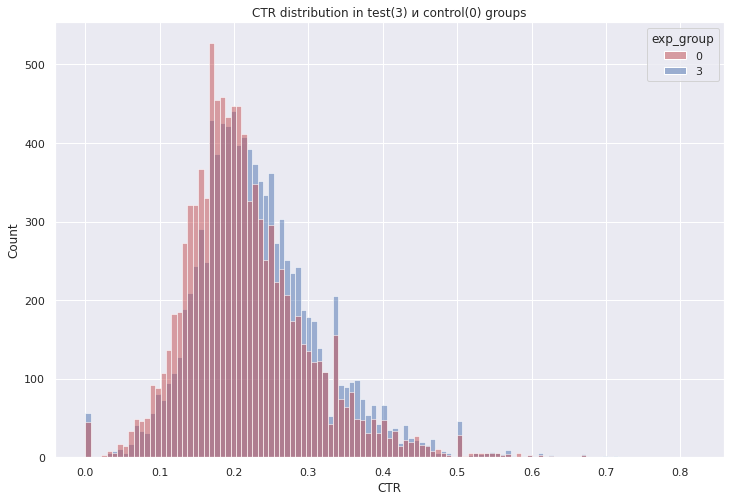

In [82]:
# Отрегулируем размер графиков в seaborn 
sns.set(rc={'figure.figsize':(12,8)})

# Зададим параметры гистограммы, показывающей распределение CTR
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.title('CTR distribution in test(3) и control(0) groups')
plt.xlabel('CTR')
plt.show()

3. "На глаз" распределение выглядит нормальным, одномодальным. Проведем обычный t-test

In [83]:
print(f"P-value = {stats.ttest_ind(df[df.exp_group == 0].ctr,df[df.exp_group == 3].ctr,equal_var=False)[1]}")

P-value = 1.055849414662529e-43


В результате обычного т-теста P-value получился гораздо меньше 0.05. Следовательно, мы не можем принять нулевую гипотезу, и различия между средними значениями являются статистически значимыми.

3. Теперь проанализируем группы 0 и 3 по метрике линеаризованных лайков.

In [101]:
CTRcontrol_0 = (df[df.exp_group == 0]['likes'].sum())/(df[df.exp_group == 0]['views'].sum())
CTRcontrol_3 = (df[df.exp_group == 3]['likes'].sum())/(df[df.exp_group == 3]['views'].sum())

In [85]:
linearized_likes_0 = df[df.exp_group == 0]['likes'] - (CTRcontrol_0*(df[df.exp_group == 0]['views']))
linearized_likes_3 = df[df.exp_group == 3]['likes'] - (CTRcontrol_0*(df[df.exp_group == 3]['views']))

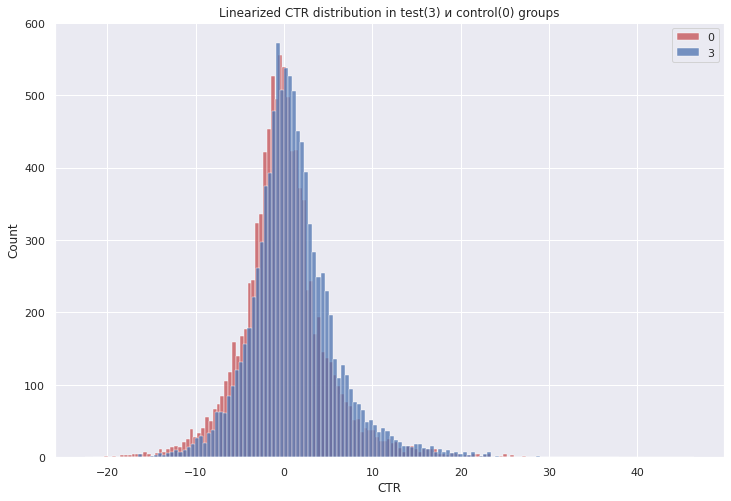

In [104]:
# Отрегулируем размер графиков в seaborn 
sns.set(rc={'figure.figsize':(12,8)})

# Зададим параметры гистограммы, показывающей распределение CTR
sns.histplot(linearized_likes_0, color='r', label='0')
sns.histplot(linearized_likes_3, color='b', label='3')
plt.title('Linearized CTR distribution in test(3) и control(0) groups')
plt.xlabel('CTR')
plt.legend()
plt.show()

In [87]:
print(f"Linearized P-value = {stats.ttest_ind(linearized_likes_0,linearized_likes_3,equal_var=False)[1]}")

Linearized P-value = 5.4914249479690016e-52


В целом распределение стало более ровным, как бы сгладилось. Значение Linearized P-value оказалось еще меньше, чем при обычном т-тесте. С одной стороны, это подтверждает наличие статистичски значимого различия между средними обеих групп. С другой, Linearized P-value можно назвать более чувствительной метрикой.

4. Проведем сравнение тестов между группами 1 и 2

In [96]:
# Создаем запрос
q2 = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

# Загружаем данные из clickhouse
df2 = ph.read_clickhouse(q2, connection=connection)

In [97]:
df2

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


Посмотрим на наше распределение

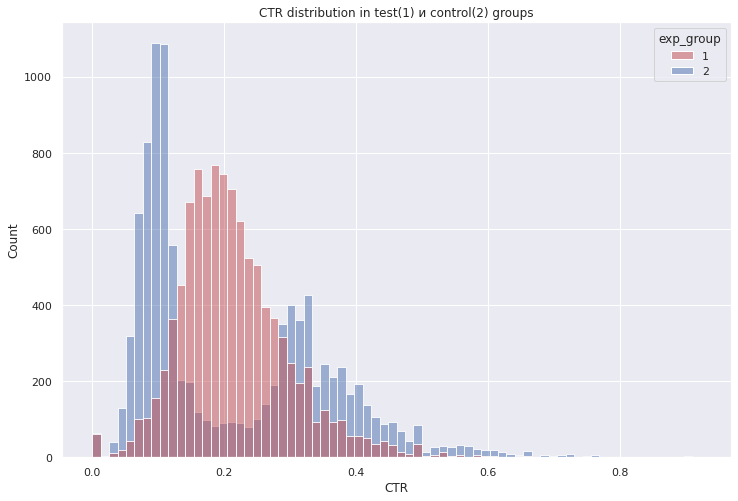

In [98]:
# Отрегулируем размер графиков в seaborn 
sns.set(rc={'figure.figsize':(12,8)})

# Зададим параметры гистограммы, показывающей распределение CTR
groups = sns.histplot(data = df2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.title('CTR distribution in test(1) и control(2) groups')
plt.xlabel('CTR')
plt.show()

5. Распределение ctr в первой группы можно назвать нормальным. Распределение ctr во второй группе - двумодальным. Проведем обычный т-тест.

In [100]:
print(f"P-value = {stats.ttest_ind(df2[df2.exp_group == 1].ctr,df2[df2.exp_group == 2].ctr,equal_var=False)[1]}")

P-value = 0.4780623130874935


При обычном т-тесте P-value больше 0.05. Следовательно, различия между средними значениями не являются статистически значимыми. Однако даже "на глаз" видно, что отличия есть. Обычный т-тест, как правило, не следует применять при ненормальных распределениях.

6. Проанализируем группы 1 и 2 по метрике линеаризованных лайков.

In [106]:
CTRcontrol_1 = (df2[df2.exp_group == 1]['likes'].sum())/(df2[df2.exp_group == 1]['views'].sum())
CTRcontrol_2 = (df2[df2.exp_group == 2]['likes'].sum())/(df2[df2.exp_group == 2]['views'].sum())

In [107]:
linearized_likes_1 = df2[df2.exp_group == 1]['likes'] - (CTRcontrol_1*(df2[df2.exp_group == 1]['views']))
linearized_likes_2 = df2[df2.exp_group == 2]['likes'] - (CTRcontrol_1*(df2[df2.exp_group == 2]['views']))

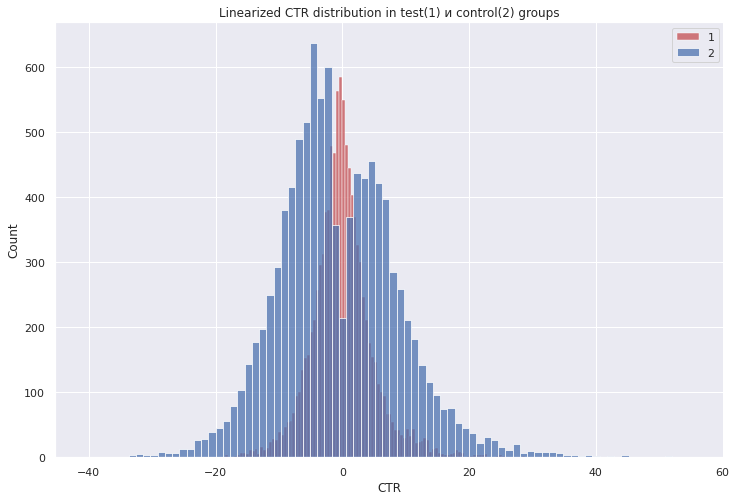

In [110]:
# Отрегулируем размер графиков в seaborn 
sns.set(rc={'figure.figsize':(12,8)})

# Зададим параметры гистограммы, показывающей распределение CTR
sns.histplot(linearized_likes_1, color='r', label='1')
sns.histplot(linearized_likes_2, color='b', label='2')
plt.title('Linearized CTR distribution in test(1) и control(2) groups')
plt.xlabel('CTR')
plt.legend()
plt.show()

In [111]:
print(f"Linearized P-value = {stats.ttest_ind(linearized_likes_1,linearized_likes_2,equal_var=False)[1]}")

Linearized P-value = 9.439432187037712e-10


7. А вот здесь уже сразу видно, что значение Linearized P-value оказалось обратным и более достоверным, в отличие от P-value обычного т-теста. Linearized P-value намного меньше 0.05. Следовательно, различия в группах статистически значимы.

Вывод: Чувствительность метрики линеаризованных лайков действительно выше стандартного т-теста. Более того, при ненормальности распределения данных метод анализа с применением метрики линеаризованных лайков оказался гораздо более достоверным и объективным.

P.S. Задание действительно очень интересное! Здорово, когда буквально своими глазами можно увидеть различия в работе разных методов и понять, в каких случаях предпотительно применять каждый. Спасибо! ))